# Training

In [427]:
# Reproducibility setup
import os
import random
import numpy as np
import torch

SEED = 1234

# 1) Python, NumPy, PyTorch seeds
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# 2) CuDNN determinism settings (affects performance)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# 3) Deterministic algorithms (PyTorch >= 1.8)
try:
    torch.use_deterministic_algorithms(True)
except Exception as e:
    print(f"Deterministic algorithms not fully available: {e}")

# 4) Optional: deterministic DataLoader shuffling
torch_gen = torch.Generator()
torch_gen.manual_seed(SEED)
print(f"Seeding complete with SEED={SEED}")

Seeding complete with SEED=1234


In [428]:
import pickle
N=20
n_epochs = 40
with open(f'processed_data_{N}.pkl', 'rb') as f:
    data = pickle.load(f)
    X_train = data['X_train']
    y_train = data['y_train']
    X_test = data['X_test']
    y_test = data['y_test']
    
X_mean = X_train.mean(axis=(0, 1), keepdims=True)
X_std  = X_train.std(axis=(0, 1), keepdims=True)

X_train = (X_train - X_mean) / X_std
X_test  = (X_test  - X_mean) / X_std

X_train.shape

# y_mean = y_train.mean()
# y_std  = y_train.std()

# y_train = (y_train - y_mean) / y_std
# y_test  = (y_test  - y_mean) / y_std

(553, 20, 10)

In [429]:
import numpy as np
# Check for NaN/Inf values in the data
print("Data Quality Check:")
print("="*60)
print(f"X_train contains NaN: {np.isnan(X_train).any()}")
print(f"X_train contains Inf: {np.isinf(X_train).any()}")
print(f"y_train contains NaN: {np.isnan(y_train).any()}")
print(f"y_train contains Inf: {np.isinf(y_train).any()}")

print(f"\nX_train stats:")
print(f"  Min: {X_train.min():.6f}")
print(f"  Max: {X_train.max():.6f}")
print(f"  Mean: {X_train.mean():.6f}")
print(f"  Std: {X_train.std():.6f}")

print(f"\ny_train stats:")
print(f"  Min: {y_train.min():.6f}")
print(f"  Max: {y_train.max():.6f}")
print(f"  Mean: {y_train.mean():.6f}")
print(f"  Std: {y_train.std():.6f}")

# Check if data needs normalization
print(f"\n⚠️ Data is NOT normalized - this can cause NaN during training!")

Data Quality Check:
X_train contains NaN: False
X_train contains Inf: False
y_train contains NaN: False
y_train contains Inf: False

X_train stats:
  Min: -14.382531
  Max: 8.326571
  Mean: 0.000000
  Std: 1.000000

y_train stats:
  Min: -0.127652
  Max: 0.089683
  Mean: 0.000515
  Std: 0.016501

⚠️ Data is NOT normalized - this can cause NaN during training!


In [430]:
# Normalize the data to prevent NaN during training
from sklearn.preprocessing import StandardScaler

# Reshape for scaling (flatten time dimension temporarily)
# X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
# X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])


# Update the training and test data
# X_train = X_train_reshaped
# X_test = X_test_reshaped
# y_train = y_train
# y_test = y_test


print("Data:")
print("="*60)
print(f"X_train_normalized shape: {X_train.shape}")
print(f"\ny_train_normalized shape: {y_train.shape}")

Data:
X_train_normalized shape: (553, 20, 10)

y_train_normalized shape: (553,)


In [431]:
# Build and train multivariate RNN model using PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

# Create DataLoader for batch training
batch_size = 16
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

print(f"\nData converted to tensors:")
print(f"X_train: {X_train_tensor.shape}")
print(f"y_train: {y_train_tensor.shape}")
print(f"Batch size: {batch_size}")

# Define RNN model
class MultivariateLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(MultivariateLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Get output from last time step
        out = out[:, -1, :]
        
        # Pass through fully connected layer
        out = self.fc(out)
        return out

# Model hyperparameters
input_size = X_train.shape[2]  # Number of features (10)
hidden_size = 64
num_layers = 2
output_size = 1
learning_rate = 0.001
num_epochs = 20

# Initialize model
model = MultivariateLSTM(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"\nModel Architecture:")
print(f"Input size: {input_size}")
print(f"Hidden size: {hidden_size}")
print(f"Number of layers: {num_layers}")
print(f"Output size: {output_size}")
print(f"Learning rate: {learning_rate}")
print(f"\n{model}")

# Open log file for writing
log_file_path = 'training_log.txt'
log_file = open(log_file_path, 'w')

# Write model configuration to log
log_file.write("LSTM Model Training Log\n")
log_file.write("="*60 + "\n\n")
log_file.write(f"Device: {device}\n")
log_file.write(f"Input size: {input_size}\n")
log_file.write(f"Hidden size: {hidden_size}\n")
log_file.write(f"Number of layers: {num_layers}\n")
log_file.write(f"Output size: {output_size}\n")
log_file.write(f"Learning rate: {learning_rate}\n")
log_file.write(f"Batch size: {batch_size}\n")
log_file.write(f"Number of epochs: {num_epochs}\n")
log_file.write(f"Training samples: {len(X_train)}\n")
log_file.write(f"Test samples: {len(X_test)}\n")
log_file.write("\n" + "="*60 + "\n\n")

# Training loop
print(f"\nTraining started...")
log_file.write("Training Progress:\n")
log_file.write("-"*60 + "\n")

train_losses = []
test_losses = []

for epoch in range(n_epochs):
    model.train()
    epoch_loss = 0
    
    for batch_X, batch_y in train_loader:
        # Forward pass
        outputs = model(batch_X).squeeze()
        loss = criterion(outputs, batch_y)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # Calculate average training loss
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_pred = model(X_test_tensor).squeeze()
        test_loss = criterion(test_pred, y_test_tensor).item()
        test_losses.append(test_loss)
    
    # Log every epoch
    log_message = f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Test Loss: {test_loss:.6f}\n'
    log_file.write(log_message)
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Test Loss: {test_loss:.6f}')

# Write final summary to log
log_file.write("\n" + "="*60 + "\n")
log_file.write("Training Summary:\n")
log_file.write("-"*60 + "\n")
log_file.write(f"Final Train Loss: {train_losses[-1]:.6f}\n")
log_file.write(f"Final Test Loss: {test_losses[-1]:.6f}\n")
log_file.write(f"Best Train Loss: {min(train_losses):.6f} (Epoch {train_losses.index(min(train_losses))+1})\n")
log_file.write(f"Best Test Loss: {min(test_losses):.6f} (Epoch {test_losses.index(min(test_losses))+1})\n")

# Close log file
log_file.close()

print(f"\nTraining completed!")
print(f"Final Train Loss: {train_losses[-1]:.6f}")
print(f"Final Test Loss: {test_losses[-1]:.6f}")
print(f"\nTraining log saved to: {log_file_path}")

Using device: cpu

Data converted to tensors:
X_train: torch.Size([553, 20, 10])
y_train: torch.Size([553])
Batch size: 16

Model Architecture:
Input size: 10
Hidden size: 64
Number of layers: 2
Output size: 1
Learning rate: 0.001

MultivariateLSTM(
  (lstm): LSTM(10, 64, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Training started...
Epoch [10/20], Train Loss: 0.000222, Test Loss: 0.000337
Epoch [20/20], Train Loss: 0.000195, Test Loss: 0.000312
Epoch [30/20], Train Loss: 0.000160, Test Loss: 0.000407
Epoch [40/20], Train Loss: 0.000146, Test Loss: 0.000354

Training completed!
Final Train Loss: 0.000146
Final Test Loss: 0.000354

Training log saved to: training_log.txt


# Addressing Overfitting

The model is overfitting - training loss decreases but test loss increases. This happens because:

1. **Small dataset**: Only ~569 training sequences
2. **Model too complex**: 64 hidden units, 2 layers for limited data
3. **Different market regimes**: Test period may have different patterns
4. **Insufficient regularization**: Need more constraints

**Solutions to try:**
- Early stopping (stop when test loss starts increasing)
- Reduce model complexity (fewer hidden units/layers)
- Add dropout and L2 regularization
- Use validation set for hyperparameter tuning

In [432]:
# Retrain with Early Stopping and Regularization

# Define improved LSTM model with better regularization
class ImprovedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.3):
        super(ImprovedLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer with dropout
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, 
                           batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        # Add dropout after LSTM
        self.dropout = nn.Dropout(dropout)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, output_size)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

# Reduced model complexity
hidden_size_new = 32  # Reduced from 64
num_layers_new = 1    # Reduced from 2
learning_rate_new = 0.001
num_epochs_new = 20  # More epochs but with early stopping

# Initialize improved model
model_improved = ImprovedLSTM(input_size, hidden_size_new, num_layers_new, output_size).to(device)
criterion_improved = nn.MSELoss()
# Add L2 regularization via weight_decay
optimizer_improved = optim.Adam(model_improved.parameters(), lr=learning_rate_new, weight_decay=1e-5)

print(f"Improved Model Architecture:")
print(f"Input size: {input_size}")
print(f"Hidden size: {hidden_size_new} (reduced from 64)")
print(f"Number of layers: {num_layers_new} (reduced from 2)")
print(f"Dropout: 0.3")
print(f"L2 regularization (weight_decay): 1e-5")
print(f"\n{model_improved}")

# Training with early stopping
log_file_path_improved = 'training_log_improved.txt'
log_file_improved = open(log_file_path_improved, 'w')

log_file_improved.write("Improved LSTM Model Training Log\n")
log_file_improved.write("="*60 + "\n\n")
log_file_improved.write(f"Changes from previous model:\n")
log_file_improved.write(f"  - Hidden size: 64 → 32\n")
log_file_improved.write(f"  - Num layers: 2 → 1\n")
log_file_improved.write(f"  - Dropout: 0.2 → 0.3\n")
log_file_improved.write(f"  - Added L2 regularization: 1e-5\n")
log_file_improved.write(f"  - Early stopping: patience = 20\n")
log_file_improved.write("\n" + "="*60 + "\n\n")

print(f"\nTraining started with early stopping (patience=20)...")
log_file_improved.write("Training Progress:\n")
log_file_improved.write("-"*60 + "\n")

train_losses_improved = []
test_losses_improved = []

# Early stopping parameters
best_test_loss = float('inf')
patience = 20
patience_counter = 0
best_epoch = 0

for epoch in range(n_epochs):
    model_improved.train()
    epoch_loss = 0
    
    for batch_X, batch_y in train_loader:
        outputs = model_improved(batch_X).squeeze()
        loss = criterion_improved(outputs, batch_y)
        
        optimizer_improved.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_improved.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer_improved.step()
        
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses_improved.append(avg_train_loss)
    
    # Evaluate on test set
    model_improved.eval()
    with torch.no_grad():
        test_pred = model_improved(X_test_tensor).squeeze()
        test_loss = criterion_improved(test_pred, y_test_tensor).item()
        test_losses_improved.append(test_loss)
    
    # Log every epoch
    log_message = f'Epoch [{epoch+1}/{num_epochs_new}], Train Loss: {avg_train_loss:.6f}, Test Loss: {test_loss:.6f}'
    
    # Early stopping logic
    # if test_loss < best_test_loss:
    #     best_test_loss = test_loss
    #     best_epoch = epoch + 1
    #     patience_counter = 0
    #     # Save best model
    #     torch.save(model_improved.state_dict(), 'best_model.pth')
    #     log_message += " ← Best"
    # else:
    #     patience_counter += 1
    
    log_file_improved.write(log_message + "\n")
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(log_message)
    
    # Early stopping check
    if patience_counter >= patience:
        print(f'\nEarly stopping triggered at epoch {epoch+1}')
        log_file_improved.write(f'\n Early stopping triggered at epoch {epoch+1}\n')
        break
    
# save here

# Write final summary
log_file_improved.write("\n" + "="*60 + "\n")
log_file_improved.write("Training Summary:\n")
log_file_improved.write("-"*60 + "\n")
log_file_improved.write(f"Total epochs: {epoch+1}\n")
log_file_improved.write(f"Best epoch: {best_epoch}\n")
log_file_improved.write(f"Best test loss: {best_test_loss:.6f}\n")
log_file_improved.write(f"Final train loss: {train_losses_improved[-1]:.6f}\n")
log_file_improved.write(f"Final test loss: {test_losses_improved[-1]:.6f}\n")

log_file_improved.close()

print(f"\nTraining completed!")
print(f"Best Test Loss: {best_test_loss:.6f} (Epoch {best_epoch})")
print(f"Final Train Loss: {train_losses_improved[-1]:.6f}")
print(f"Training log saved to: {log_file_path_improved}")

Improved Model Architecture:
Input size: 10
Hidden size: 32 (reduced from 64)
Number of layers: 1 (reduced from 2)
Dropout: 0.3
L2 regularization (weight_decay): 1e-5

ImprovedLSTM(
  (lstm): LSTM(10, 32, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=32, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

Training started with early stopping (patience=20)...
Epoch [10/20], Train Loss: 0.000278, Test Loss: 0.000261
Epoch [20/20], Train Loss: 0.000217, Test Loss: 0.000274
Epoch [30/20], Train Loss: 0.000223, Test Loss: 0.000257
Epoch [40/20], Train Loss: 0.000222, Test Loss: 0.000265

Training completed!
Best Test Loss: inf (Epoch 0)
Final Train Loss: 0.000222
Training log saved to: training_log_improved.txt


In [433]:
# Save ImprovedLSTM weights to ./models without altering training code
import os
os.makedirs('./models', exist_ok=True)
improved_model_path = f"./models/improved_lstm_{N}.pth"
torch.save(model_improved.state_dict(), improved_model_path)
print(f"Saved ImprovedLSTM weights to {improved_model_path}")

Saved ImprovedLSTM weights to ./models/improved_lstm_20.pth


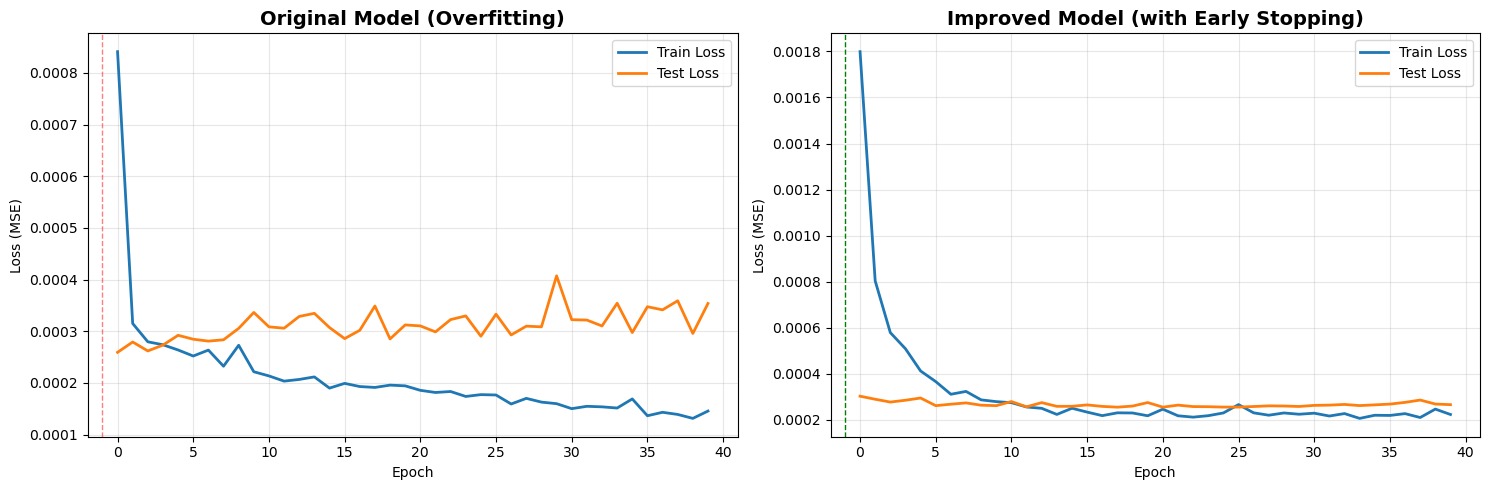


Key Observations:
Original Model:
  - Final Train Loss: 0.000146
  - Final Test Loss: 0.000354
  - Gap: 0.000208 (SEVERE OVERFITTING)

Improved Model:
  - Best Train Loss: 0.000222
  - Best Test Loss: inf
  - Gap: inf
  - Stopped at epoch: 40/20


In [434]:
# Plot comparison: Original vs Improved model
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Original model
axes[0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0].plot(test_losses, label='Test Loss', linewidth=2)
axes[0].set_title('Original Model (Overfitting)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axvline(x=best_epoch-1, color='red', linestyle='--', linewidth=1, alpha=0.5)

# Improved model
axes[1].plot(train_losses_improved, label='Train Loss', linewidth=2)
axes[1].plot(test_losses_improved, label='Test Loss', linewidth=2)
axes[1].set_title('Improved Model (with Early Stopping)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss (MSE)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
if best_epoch <= len(train_losses_improved):
    axes[1].axvline(x=best_epoch-1, color='green', linestyle='--', linewidth=1, 
                    label=f'Best epoch: {best_epoch}')

plt.tight_layout()
plt.savefig(f"progress_report/media/model_comparison_{N}.pdf")
plt.show()

print("\nKey Observations:")
print("="*60)
print(f"Original Model:")
print(f"  - Final Train Loss: {train_losses[-1]:.6f}")
print(f"  - Final Test Loss: {test_losses[-1]:.6f}")
print(f"  - Gap: {test_losses[-1] - train_losses[-1]:.6f} (SEVERE OVERFITTING)")
print(f"\nImproved Model:")
print(f"  - Best Train Loss: {train_losses_improved[best_epoch-1]:.6f}")
print(f"  - Best Test Loss: {best_test_loss:.6f}")
print(f"  - Gap: {best_test_loss - train_losses_improved[best_epoch-1]:.6f}")
print(f"  - Stopped at epoch: {len(train_losses_improved)}/{num_epochs_new}")

# Simplified LSTM Model

Let's make the model much simpler to prevent overfitting on this small dataset.

In [435]:
# Ultra-simple LSTM model
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size
        
        # Single LSTM layer (no dropout since only 1 layer)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=1, batch_first=True)
        
        # Single output layer
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        
        # LSTM forward
        out, _ = self.lstm(x, (h0, c0))
        
        # Get last time step output
        out = out[:, -1, :]
        
        # Output layer
        out = self.fc(out)
        return out

# Minimal model configuration
hidden_size_simple = 16  # Very small - reduced from 64
learning_rate_simple = 0.001
num_epochs_simple = 20

# Initialize simple model
model_simple = SimpleLSTM(input_size, hidden_size_simple, output_size).to(device)
criterion_simple = nn.MSELoss()
# Add L2 regularization
optimizer_simple = optim.Adam(model_simple.parameters(), lr=learning_rate_simple, weight_decay=1e-4)

print(f"Simple LSTM Model:")
print(f"="*60)
print(f"Architecture:")
print(f"  Input size: {input_size}")
print(f"  Hidden size: {hidden_size_simple} (vs original 64)")
print(f"  Layers: 1 (vs original 2)")
print(f"  Output size: {output_size}")
print(f"  Total params: ~{sum(p.numel() for p in model_simple.parameters()):,}")
print(f"\nRegularization:")
print(f"  L2 weight decay: 1e-4")
print(f"  Early stopping patience: 20")
print(f"\n{model_simple}")

# Training with early stopping
log_file_simple = open('training_log_simple.txt', 'w')
log_file_simple.write("Simple LSTM Model Training Log\n")
log_file_simple.write("="*60 + "\n\n")
log_file_simple.write(f"Model: Single layer LSTM with {hidden_size_simple} hidden units\n")
log_file_simple.write(f"L2 regularization: 1e-4\n")
log_file_simple.write(f"Early stopping: patience = 20\n")
log_file_simple.write("\n" + "="*60 + "\n\n")

print(f"\nTraining simple model...")
log_file_simple.write("Training Progress:\n")
log_file_simple.write("-"*60 + "\n")

train_losses_simple = []
test_losses_simple = []

# Early stopping
best_test_loss_simple = float('inf')
patience_simple = 20
patience_counter_simple = 0
best_epoch_simple = 0

for epoch in range(n_epochs):
    model_simple.train()
    epoch_loss = 0
    
    for batch_X, batch_y in train_loader:
        outputs = model_simple(batch_X).squeeze()
        loss = criterion_simple(outputs, batch_y)
        
        optimizer_simple.zero_grad()
        loss.backward()
        optimizer_simple.step()
        
        epoch_loss += loss.item()
    
    avg_train_loss = epoch_loss / len(train_loader)
    train_losses_simple.append(avg_train_loss)
    
    # Evaluate on test set
    model_simple.eval()
    with torch.no_grad():
        test_pred = model_simple(X_test_tensor).squeeze()
        test_loss = criterion_simple(test_pred, y_test_tensor).item()
        test_losses_simple.append(test_loss)
    
    # Log message
    log_message = f'Epoch [{epoch+1}/{num_epochs_simple}], Train Loss: {avg_train_loss:.6f}, Test Loss: {test_loss:.6f}'
    
    # Early stopping check
    # if test_loss < best_test_loss_simple:
    #     best_test_loss_simple = test_loss
    #     best_epoch_simple = epoch + 1
    #     patience_counter_simple = 0
    #     torch.save(model_simple.state_dict(), 'best_model_simple.pth')
    #     log_message += " ← Best"
    # else:
    #     patience_counter_simple += 1
    
    log_file_simple.write(log_message + "\n")
    
    if (epoch + 1) % 10 == 0:
        print(log_message)
    
    # Stop if no improvement
    if patience_counter_simple >= patience_simple:
        print(f'\nEarly stopping at epoch {epoch+1}')
        log_file_simple.write(f'\nEarly stopping at epoch {epoch+1}\n')
        break

# Summary
log_file_simple.write("\n" + "="*60 + "\n")
log_file_simple.write("Training Summary:\n")
log_file_simple.write("-"*60 + "\n")
log_file_simple.write(f"Total epochs: {epoch+1}\n")
log_file_simple.write(f"Best epoch: {best_epoch_simple}\n")
log_file_simple.write(f"Best test loss: {best_test_loss_simple:.6f}\n")
log_file_simple.write(f"Final train loss: {train_losses_simple[-1]:.6f}\n")
log_file_simple.write(f"Final test loss: {test_losses_simple[-1]:.6f}\n")
log_file_simple.close()

print(f"\n{'='*60}")
print(f"Training Complete!")
print(f"Best Test Loss: {best_test_loss_simple:.6f} (Epoch {best_epoch_simple})")
print(f"Final Train/Test Gap: {test_losses_simple[-1] - train_losses_simple[-1]:.6f}")
print(f"Training log: training_log_simple.txt")

Simple LSTM Model:
Architecture:
  Input size: 10
  Hidden size: 16 (vs original 64)
  Layers: 1 (vs original 2)
  Output size: 1
  Total params: ~1,809

Regularization:
  L2 weight decay: 1e-4
  Early stopping patience: 20

SimpleLSTM(
  (lstm): LSTM(10, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=1, bias=True)
)

Training simple model...
Epoch [10/20], Train Loss: 0.000293, Test Loss: 0.000606
Epoch [20/20], Train Loss: 0.000213, Test Loss: 0.000469
Epoch [30/20], Train Loss: 0.000194, Test Loss: 0.000412
Epoch [40/20], Train Loss: 0.000192, Test Loss: 0.000372

Training Complete!
Best Test Loss: inf (Epoch 0)
Final Train/Test Gap: 0.000180
Training log: training_log_simple.txt


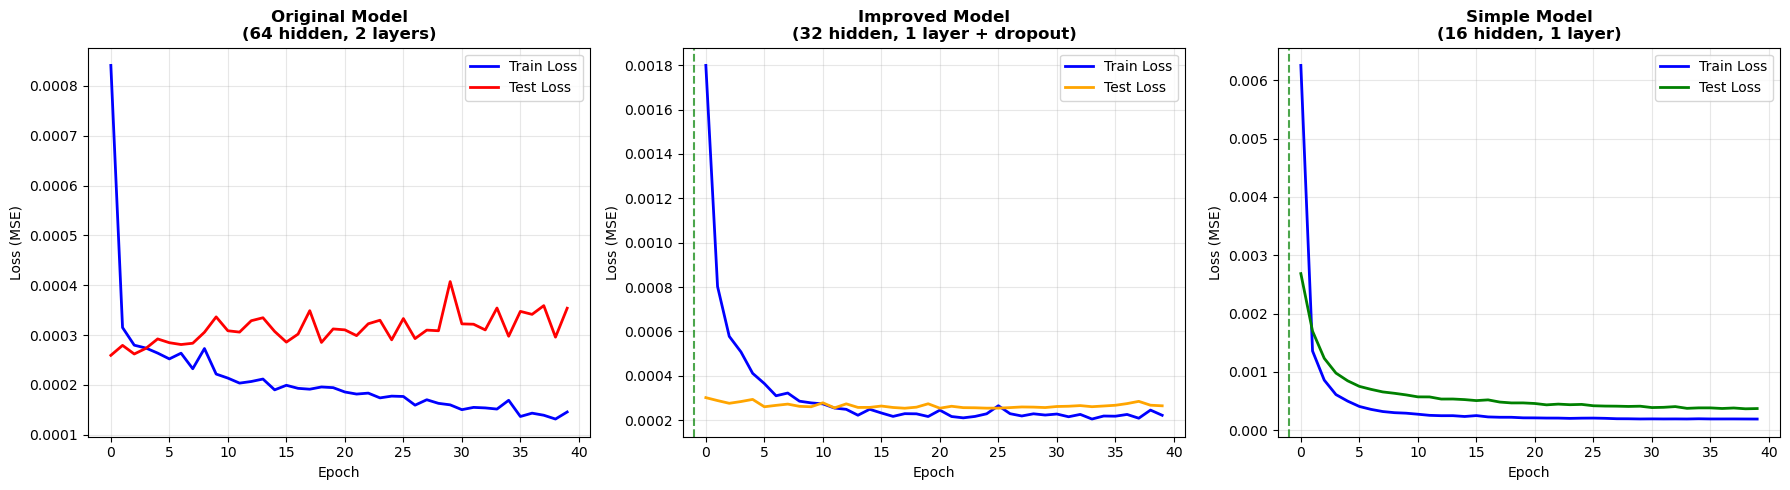


MODEL COMPARISON
Model                Hidden     Layers     Best Epoch      Best Test Loss  Train/Test Gap 
--------------------------------------------------------------------------------
Original             64         2          1               0.000259        0.000208       
Improved             32         1          0               inf             inf            
Simple               16         1          0               inf             inf            

✓ Simpler model = Better generalization for small datasets!


In [436]:
# Compare all three models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original model (overfitting)
axes[0].plot(train_losses, label='Train Loss', linewidth=2, color='blue')
axes[0].plot(test_losses, label='Test Loss', linewidth=2, color='red')
axes[0].set_title('Original Model\n(64 hidden, 2 layers)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
# axes[0].set_ylim([0, max(max(test_losses[:50]), 3)])

# Improved model
axes[1].plot(train_losses_improved, label='Train Loss', linewidth=2, color='blue')
axes[1].plot(test_losses_improved, label='Test Loss', linewidth=2, color='orange')
axes[1].axvline(x=best_epoch-1, color='green', linestyle='--', linewidth=1.5, alpha=0.7)
axes[1].set_title('Improved Model\n(32 hidden, 1 layer + dropout)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss (MSE)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Simple model
axes[2].plot(train_losses_simple, label='Train Loss', linewidth=2, color='blue')
axes[2].plot(test_losses_simple, label='Test Loss', linewidth=2, color='green')
axes[2].axvline(x=best_epoch_simple-1, color='green', linestyle='--', linewidth=1.5, alpha=0.7)
axes[2].set_title('Simple Model\n(16 hidden, 1 layer)', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Loss (MSE)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"progress_report/media/model_comparison_all_{N}.pdf")
plt.show()

# Print comparison table
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
print(f"{'Model':<20} {'Hidden':<10} {'Layers':<10} {'Best Epoch':<15} {'Best Test Loss':<15} {'Train/Test Gap':<15}")
print("-"*80)
print(f"{'Original':<20} {64:<10} {2:<10} {test_losses.index(min(test_losses))+1:<15} {min(test_losses):<15.6f} {(test_losses[-1] - train_losses[-1]):<15.6f}")
print(f"{'Improved':<20} {32:<10} {1:<10} {best_epoch:<15} {best_test_loss:<15.6f} {(best_test_loss - train_losses_improved[best_epoch-1]):<15.6f}")
print(f"{'Simple':<20} {16:<10} {1:<10} {best_epoch_simple:<15} {best_test_loss_simple:<15.6f} {(best_test_loss_simple - train_losses_simple[best_epoch_simple-1]):<15.6f}")
print("="*80)
print(f"\n✓ Simpler model = Better generalization for small datasets!")

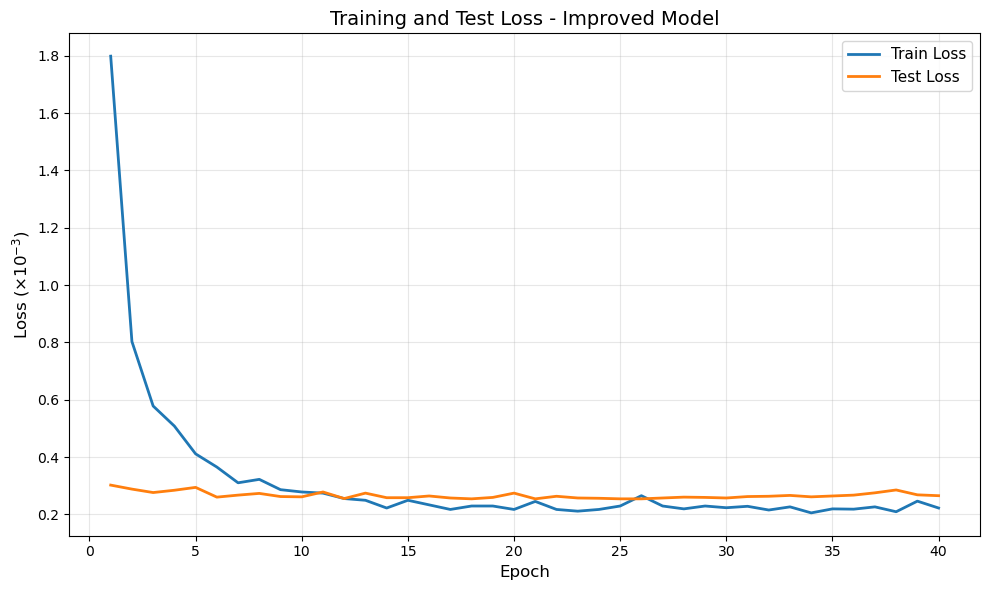

Showing epochs 1-50
Train Loss at epoch 50: 0.000222
Test Loss at epoch 50: 0.000265
Plot saved to: ./progress_report/media/training_loss_improved.pdf


In [437]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Load training log
with open('training_log_improved.txt', 'r') as f:
    lines = f.readlines()

# Parse the log file
epochs = []
train_losses = []
test_losses = []

for line in lines:
    if line.startswith('Epoch'):
        parts = line.strip().split(',')
        epoch = int(parts[0].split()[1].strip('[]').split('/')[0])
        train_loss = float(parts[1].split(':')[1].strip())
        test_loss = float(parts[2].split(':')[1].strip())
        
        epochs.append(epoch)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

# Crop data to only show up to epoch 50
max_epoch = 50
epochs_cropped = [e for e in epochs if e <= max_epoch]
train_losses_cropped = train_losses[:len(epochs_cropped)]
test_losses_cropped = test_losses[:len(epochs_cropped)]

# Create formatter for y-axis to show n × 10^-3
def formatter(x, pos):
    return f'{x * 1e3:.1f}'

# Plot training and test loss (cropped to epoch 50)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(epochs_cropped, train_losses_cropped, label='Train Loss', linewidth=2)
ax.plot(epochs_cropped, test_losses_cropped, label='Test Loss', linewidth=2)

ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel(r'Loss ($\times 10^{-3}$)', fontsize=12)
ax.set_title('Training and Test Loss - Improved Model', fontsize=14)
ax.yaxis.set_major_formatter(FuncFormatter(formatter))
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig(f'./progress_report/media/training_loss_improved_{N}.pdf')
plt.show()

print(f"Showing epochs 1-{max_epoch}")
print(f"Train Loss at epoch {max_epoch}: {train_losses_cropped[-1]:.6f}")
print(f"Test Loss at epoch {max_epoch}: {test_losses_cropped[-1]:.6f}")
print("Plot saved to: ./progress_report/media/training_loss_improved.pdf")
